In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
from urllib import request
from skimage.io import imread
import matplotlib.pyplot as plt 

# Load client id and secret id
if __name__ == "__main__":

    with open("../src/keys.py") as keys:
        exec(keys.read())

# Get client authorization

scope = "user-top-read" 
sp = spotipy.Spotify(auth_manager = SpotifyOAuth(client_id = CLIENT_ID, client_secret = SECRET_ID, scope = scope, redirect_uri = "http://localhost:8080"))

In [4]:
user_name = sp.current_user()["display_name"]
user_name


'Erick Fajardo'

In [5]:
top_artists = sp.current_user_top_artists(limit = 10, time_range = "long_term", offset = 0)
top_artists

{'items': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2ye2Wgw4gimLv2eAKyk1NB'},
   'followers': {'href': None, 'total': 0},
   'genres': ['hard rock',
    'metal',
    'old school thrash',
    'rock',
    'thrash metal'],
   'href': 'https://api.spotify.com/v1/artists/2ye2Wgw4gimLv2eAKyk1NB',
   'id': '2ye2Wgw4gimLv2eAKyk1NB',
   'images': [{'height': 640,
     'url': 'https://i.scdn.co/image/ab6761610000e5eb69ca98dd3083f1082d740e44',
     'width': 640},
    {'height': 320,
     'url': 'https://i.scdn.co/image/ab6761610000517469ca98dd3083f1082d740e44',
     'width': 320},
    {'height': 160,
     'url': 'https://i.scdn.co/image/ab6761610000f17869ca98dd3083f1082d740e44',
     'width': 160}],
   'name': 'Metallica',
   'popularity': 80,
   'type': 'artist',
   'uri': 'spotify:artist:2ye2Wgw4gimLv2eAKyk1NB'},
  {'external_urls': {'spotify': 'https://open.spotify.com/artist/4xRYI6VqpkE3UwrDrAZL8L'},
   'followers': {'href': None, 'total': 0},
   'genres': ['conscious hi

In [6]:
from PIL import Image
images = []
for i in range(len(top_artists["items"])):
    request.urlretrieve(top_artists["items"][i]["images"][0]["url"], "artist_image")
    images.append(imread("artist_image"))

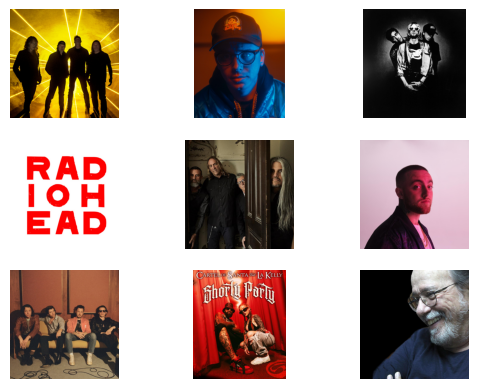

In [31]:
fig, axs = plt.subplots(nrows = 3, ncols = 3)
for i, ax in zip(images, axs.ravel()):
    ax.imshow(i)
    ax.axis("off")

plt.show()

In [18]:
# Collage
import numpy as np
import cv2
import random
import rpack
from fractions import Fraction
from math import prod

def resize_guide(image_size, unit_shape, target_ratio):
    aspect_ratio = Fraction(*image_size).limit_denominator()
    horizontal = aspect_ratio.numerator
    vertical = aspect_ratio.denominator
    target_area = prod(unit_shape) * target_ratio
    unit_length = (target_area/(horizontal*vertical))**.5
    return (int(horizontal*unit_length), int(vertical*unit_length))

def make_border(image, value, border=16):
    return cv2.copyMakeBorder(
        image,
        top=border,
        bottom=border,
        left=border,
        right=border,
        borderType=cv2.BORDER_CONSTANT,
        value=value
    )

def rotate_image(image, angle):
    h, w = image.shape[:2]
    cX, cY = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    return cv2.warpAffine(image, M, (nW, nH))

def make_collage(images,
        exponent=0.8, border=16, max_degree=15, unit_shape=(1280,720),
        resize_images=True, image_border=True, rotate_images=True, limit_shape=False):
#    images = [cv2.imread(name) for name in image_files]
    size_hint = [exponent**i for i in range(len(images))]
    
    if resize_images:
        resized_images = []
        for image, hint in zip(images, size_hint):
            height, width = image.shape[:2]
            guide = resize_guide((width, height), unit_shape, hint)
            resized = cv2.resize(image, guide, interpolation = cv2.INTER_AREA)
            if image_border:
                resized = make_border(resized, (255, 255, 255), border)
            resized_images.append(resized)
        images = resized_images
    else:
        sorted_images = []
        for image in sorted(images, key=lambda x: -prod(x.shape[:2])):
            if image_border:
                image = make_border(image, (255, 255, 255), border)
            sorted_images.append(image)
        images = sorted_images
    
    sizes = []
    processed_images = []
    for image in images:
        if rotate_images:
            image = rotate_image(image, random.randrange(-max_degree, max_degree+1))
        processed = make_border(image, (0,0,0), border)
        processed_images.append(processed)
        height, width = processed.shape[:2]
        sizes.append((width, height))
    
    if limit_shape:
        max_side = int((sum([w*h for w, h in sizes])*2)**.5)
        packed = rpack.pack(sizes, max_width=max_side, max_height=max_side)
    else:
        packed = rpack.pack(sizes)
    
    shapes = [(x, y, w, h) for (x, y), (w, h) in zip(packed, sizes)]
    rightmost = sorted(shapes, key=lambda x: -x[0] - x[2])[0]
    bound_width = rightmost[0] + rightmost[2]
    downmost = sorted(shapes, key=lambda x: -x[1] - x[3])[0]
    bound_height = downmost[1] + downmost[3]
    
    collage = np.zeros([bound_height, bound_width, 3],dtype=np.uint8)
    for image, (x, y, w, h) in zip(processed_images, shapes):
        collage[y:y+h, x:x+w] = image
    
    collage = cv2.GaussianBlur(collage, (3,3), cv2.BORDER_DEFAULT)
    plt.imshow(collage)
    plt.axis("off")
 

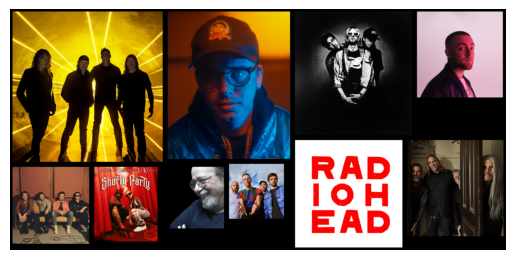

In [19]:
make_collage(images, rotate_images = False, image_border = False)